# Где дешевле жить? Предсказание цен в Airbnb

Опробованные текники.
* Была сделана стандартная предобработка признаков
* построены различные визуализации
* опробован ohe через dummies
* применены различные типы шкалирования (MinMax, StandartScaller, Robust)
* для переменной neibohood применено частотное кодирование, чтобы не перегружать число признаков
* применена помимо линейных моделей - random forest

Итоги: 
* фича превращения long и lat в расстояние от центра манхетена до недвижимости на удивление не помогла
* заметно улучшиело модель шкалирование данных, лучше всего сработало robust шкалирование
* в целом линейные модели показали примерно одинаковый результат
* random forest оказался немного лучше линейных моделей

Все итоговые метрики расположены в конце ноутбука в dataframe measured_metrics





# Часть 1. EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)


from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Lasso


%matplotlib inline
plt.rcParams["figure.figsize"] = (12,8)


np.random.seed(49)

для отображения графиков без скроллов

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
data = pd.read_csv('AB_NYC_2019.csv')

In [4]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
data.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [6]:
use_cols = data.columns[4:12].to_list() + data.columns[13:].to_list()

In [7]:
use_cols

['neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [8]:
data = pd.read_csv('AB_NYC_2019.csv', usecols=use_cols)

In [9]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [10]:
data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [12]:
data.dtypes

neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

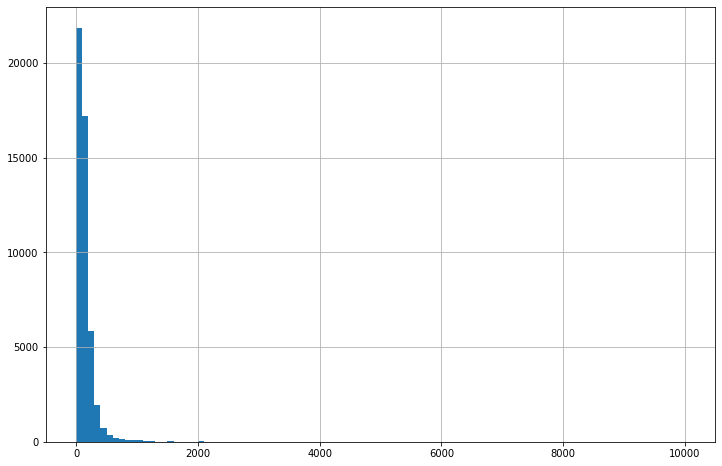

In [13]:
data.price.hist(bins = 100)

целевая переменная распределена ненормально, пока осавим ее как есть, чтобы в дальнейшем сравнить метрики  до и после предобработки.

карта района:

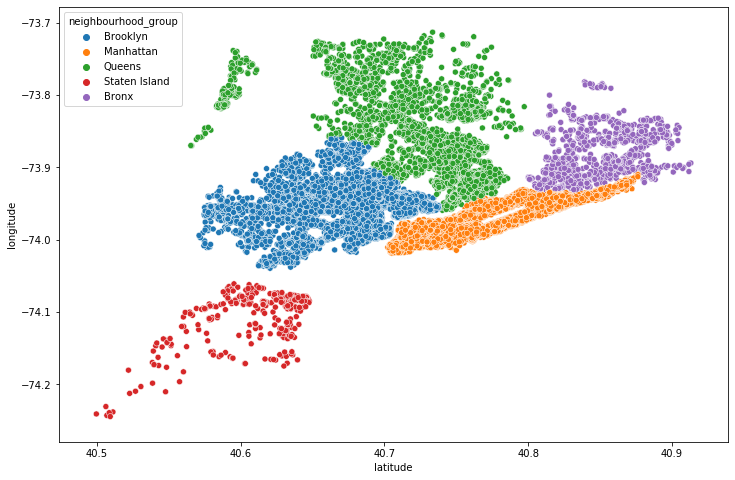

In [14]:
sns.scatterplot(data.latitude, data.longitude, hue=data.neighbourhood_group)

тип комнаты в зависимости от района

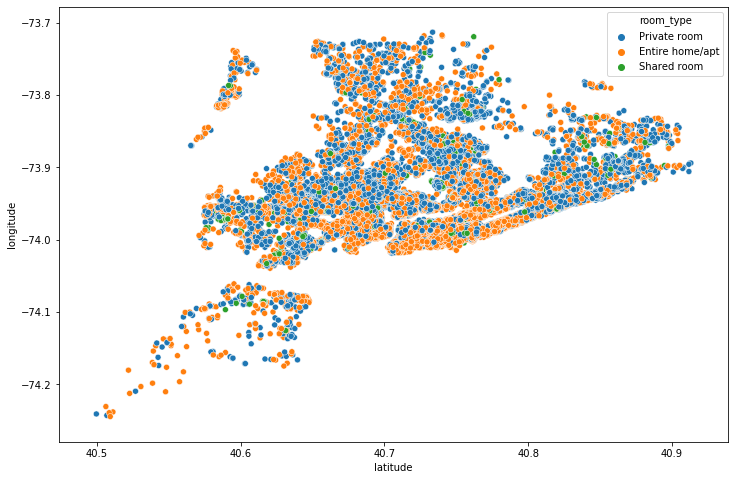

In [15]:
sns.scatterplot(data.latitude, data.longitude, hue=data.room_type)

In [16]:
data.neighbourhood_group.value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

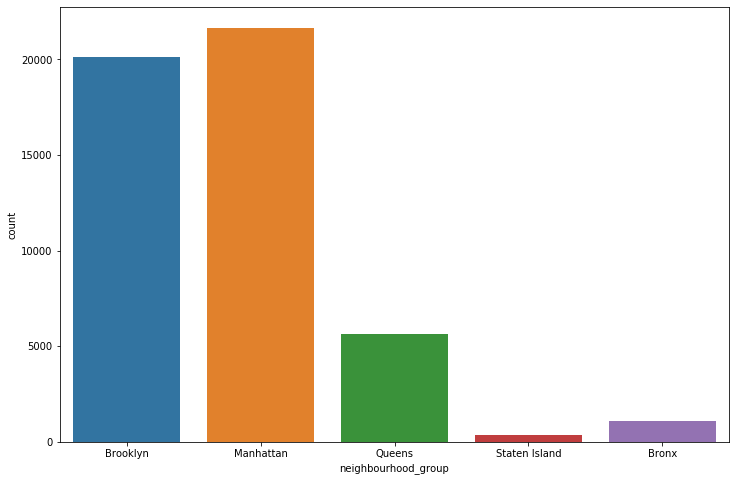

In [17]:
sns.countplot(x = data.neighbourhood_group)

проверка на дубликаты

In [18]:
data.duplicated().sum()

0

проверка на пропуски

In [19]:
data.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

гистограммы распределения признаков

In [20]:
int_colums = ['latitude', 'longitude','price','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']

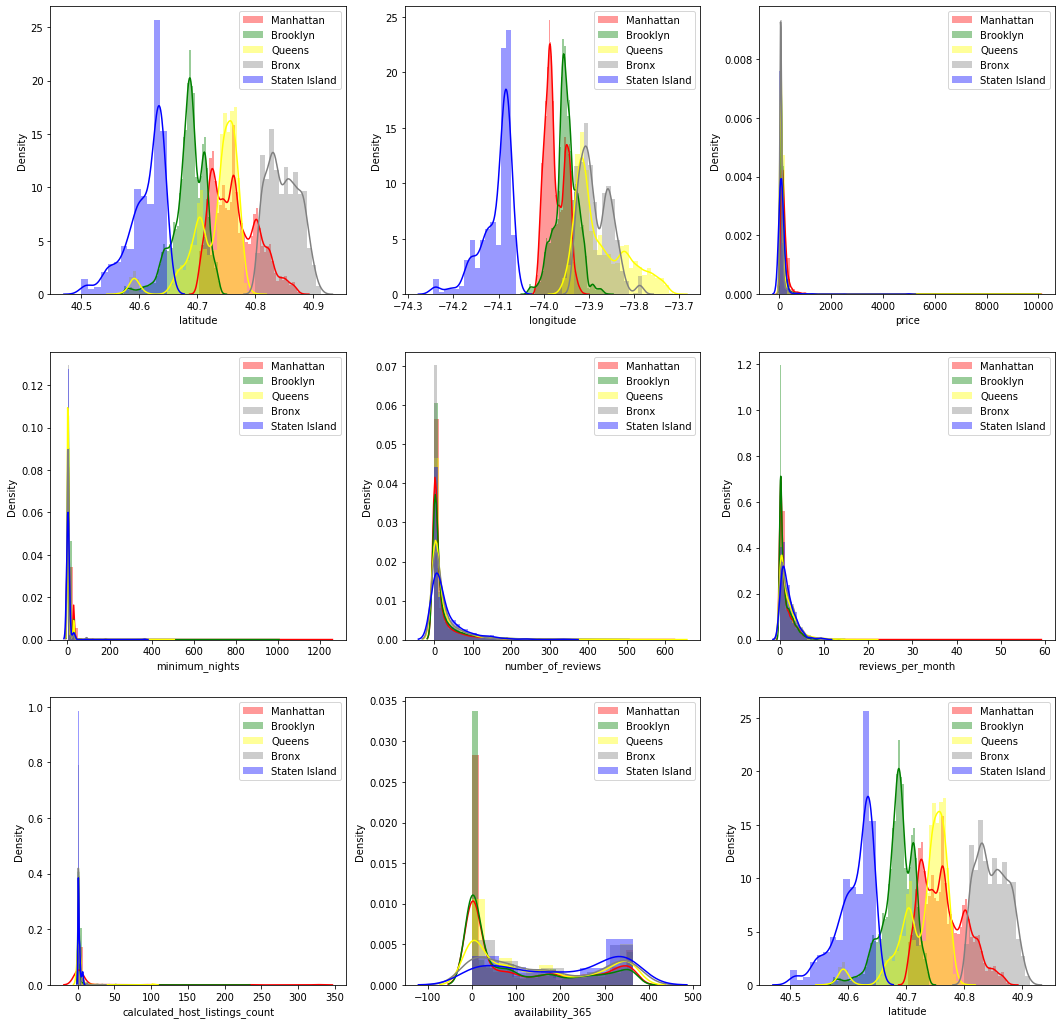

In [21]:
nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*6))
a = -8
for i in range(nrows):
    for j in range(ncols):
      ax1 = sns.distplot(data[data['neighbourhood_group'] == 'Manhattan'][int_colums[a]], ax = ax[i,j], color = 'red', label = 'Manhattan').legend()
      ax2 = sns.distplot(data[data['neighbourhood_group'] == 'Brooklyn'][int_colums[a]], ax = ax[i,j], color = 'green', label = 'Brooklyn').legend()
      ax3 = sns.distplot(data[data['neighbourhood_group'] == 'Queens'][int_colums[a]], ax = ax[i,j], color = 'yellow', label = 'Queens').legend()
      ax4 = sns.distplot(data[data['neighbourhood_group'] == 'Bronx'][int_colums[a]], ax = ax[i,j], color = 'gray', label = 'Bronx').legend()
      ax5 = sns.distplot(data[data['neighbourhood_group'] == 'Staten Island'][int_colums[a]], ax = ax[i,j], color = 'blue', label = 'Staten Island').legend()
      a +=1 
plt.show()

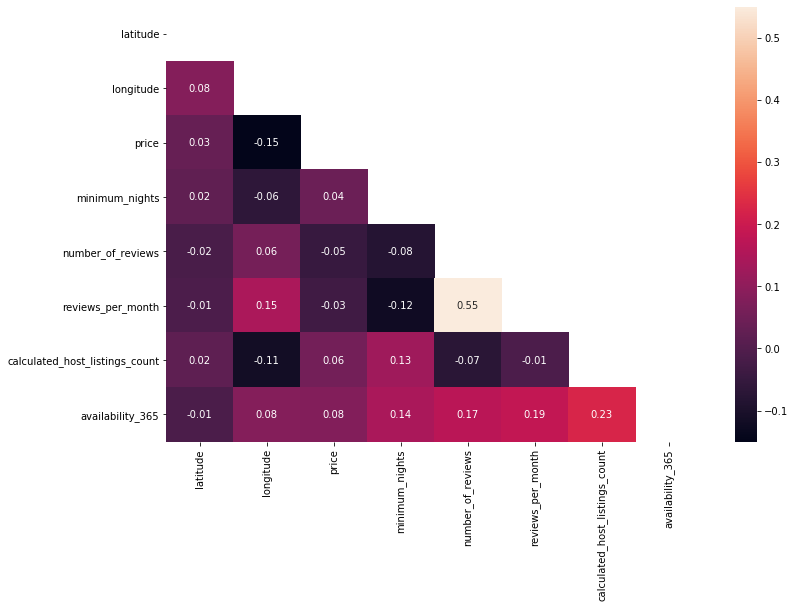

In [22]:
corr = data.corr()
sns.heatmap(corr, annot=True, fmt='.2f',  mask = np.triu(np.ones_like(corr, dtype=bool)));

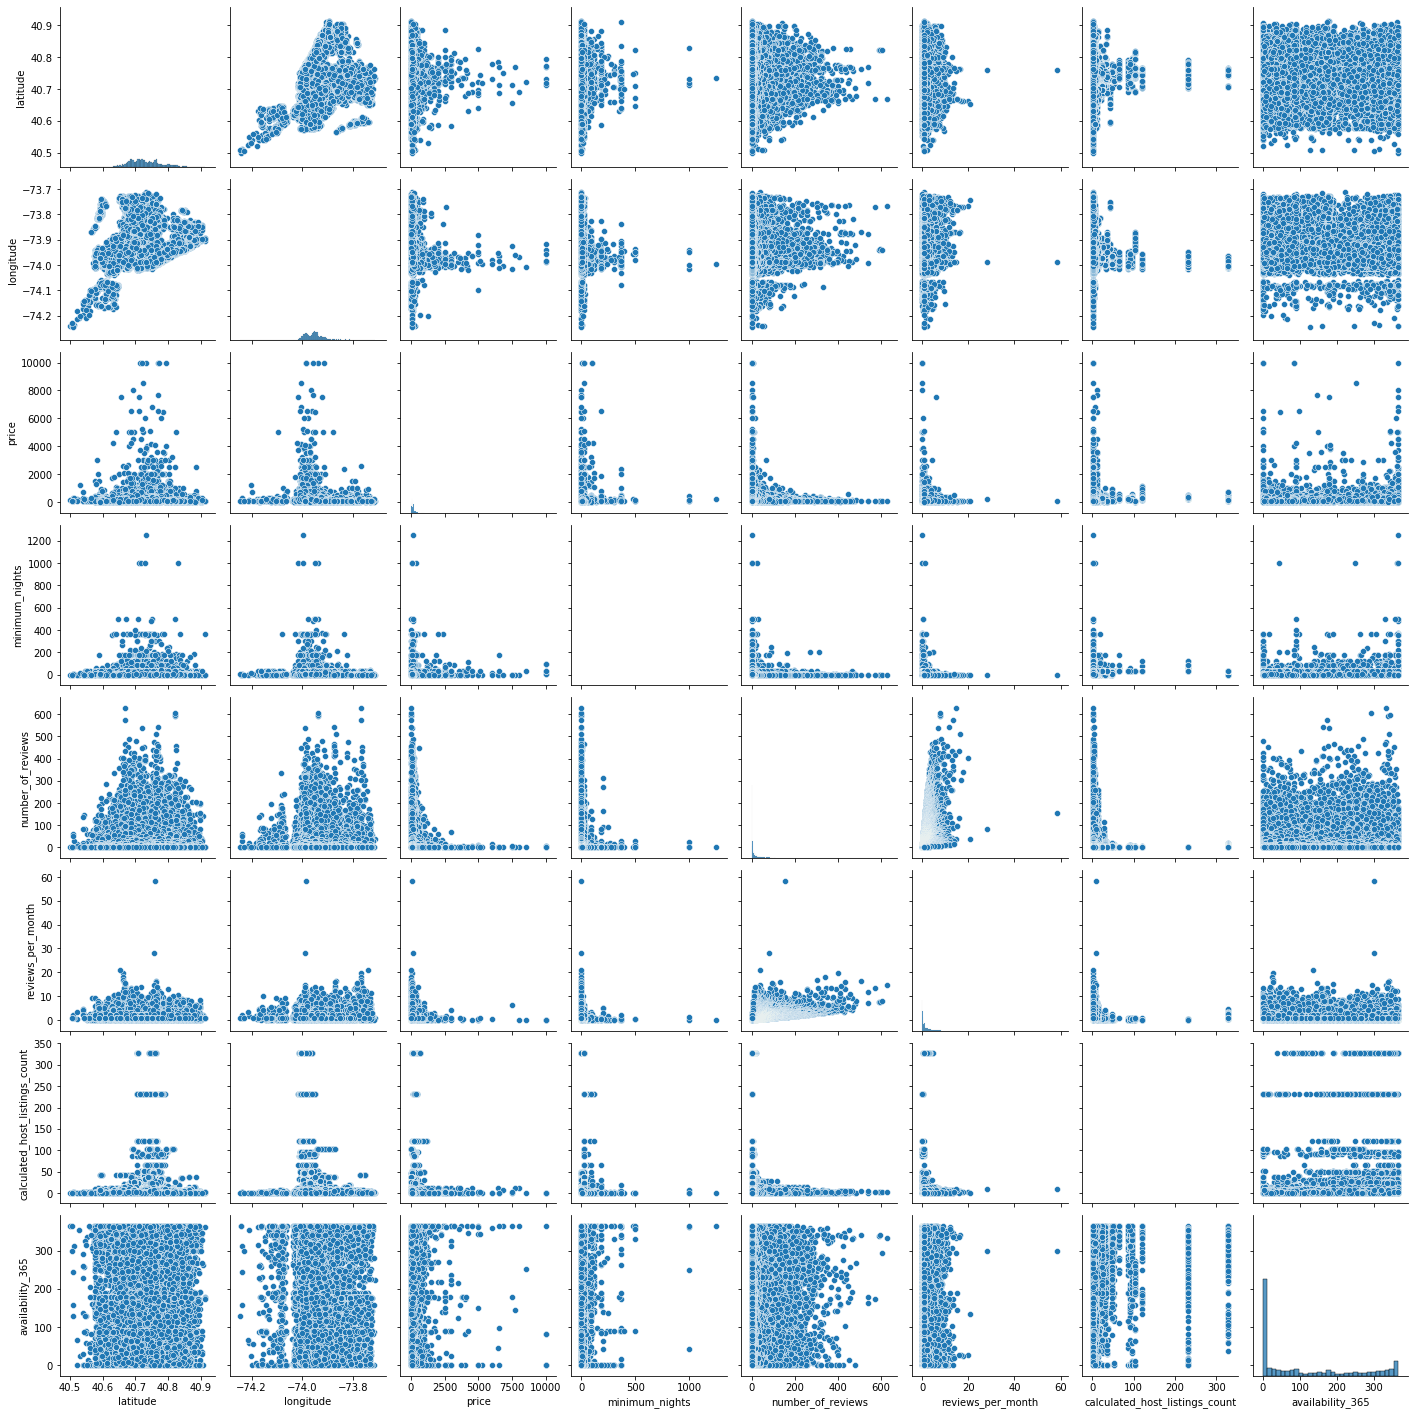

In [23]:
sns.pairplot(data)

# Часть 2. Preprocessing & Feature Engineering

### neighbourhood_group

In [24]:
data.neighbourhood_group.value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

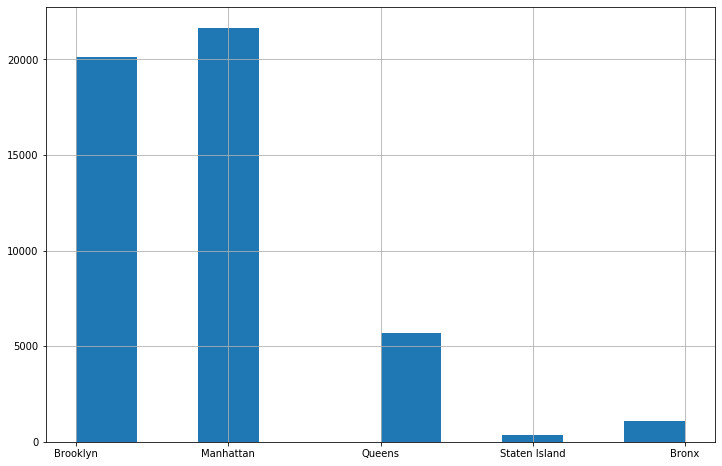

In [25]:
data.neighbourhood_group.hist()

применим one-hot encoding

In [26]:
data = pd.get_dummies(data, columns=['neighbourhood_group'],  prefix='neighbourhood_group', drop_first=True)

### neighbourhood

In [27]:
data.neighbourhood.value_counts()

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Willowbrook              1
Fort Wadsworth           1
Richmondtown             1
Woodrow                  1
New Dorp                 1
Name: neighbourhood, Length: 221, dtype: int64

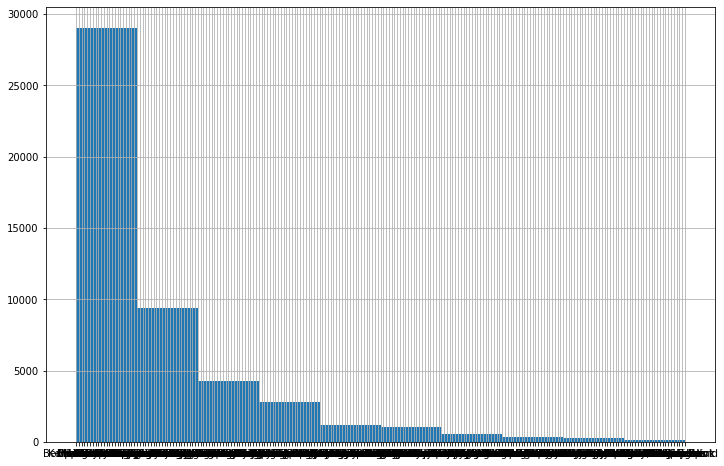

In [28]:
data.neighbourhood.hist()

применим частнотное кодирование

In [29]:
data['neighbourhood_freq'] = data['neighbourhood'].map(data['neighbourhood'].value_counts(normalize=True))

### root_type

In [30]:
data.room_type.value_counts()

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

применим one_hot_encoding

In [31]:
data = pd.get_dummies(data, columns=['room_type'],  prefix='room_type', drop_first=True)

### reviews_per_month

In [32]:
data[data.reviews_per_month.isnull()].shape

(10052, 16)

заменим null на 0 в первом случае, предположив, что null означает 0, на среднее значение, и на случайное, чтобы в последующем сравнить результаты.

In [33]:
def impute_NA_with_random(data, NA_col=None, random_state=0):
    """Заполняем пропуски случайными значениями из этой колонки."""
    NA_col = NA_col or []
    data_copy = data.copy(deep=True)
    for i in NA_col:
        if data_copy[i].isnull().sum() > 0:
            data_copy[f'{i}_random'] = data_copy[i]
            random_sample = data_copy[i].dropna().sample(data_copy[i].isnull().sum(), random_state=random_state)
            random_sample.index = data_copy[data_copy[i].isnull()].index
            data_copy.loc[data_copy[i].isnull(), f'{i}_random'] = random_sample
        else:
            warn("Нет пропущенных значений" % i)
    return data_copy 

In [34]:
data = impute_NA_with_random(data=data, NA_col=['reviews_per_month'])

In [35]:
data['reviews_per_month_mean'] = data['reviews_per_month'].fillna(data['reviews_per_month'].mean())

In [36]:
data['reviews_per_month_zero'] = data['reviews_per_month'].fillna(0)

### price

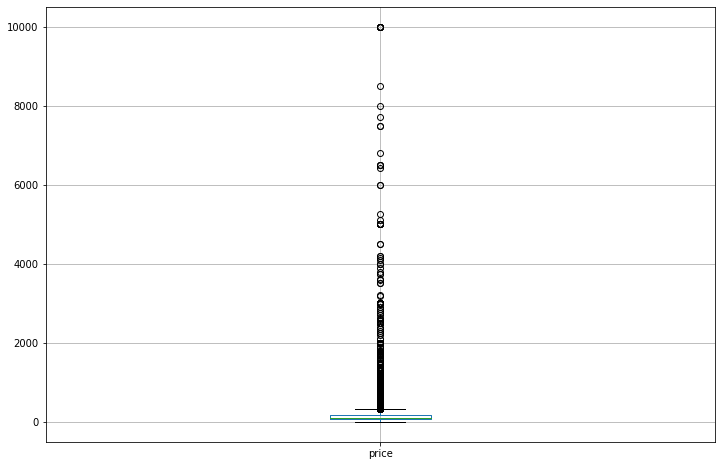

In [37]:
data.boxplot(['price'])

переменная имеет выбросы и 0 значения, а так же распределена ненормально. предлагаю удалить значения  = 0, а также прологарифмировать целевую переменную чтобы распределение стало норм - проверим это.

In [38]:
data = data[data.price > 0]

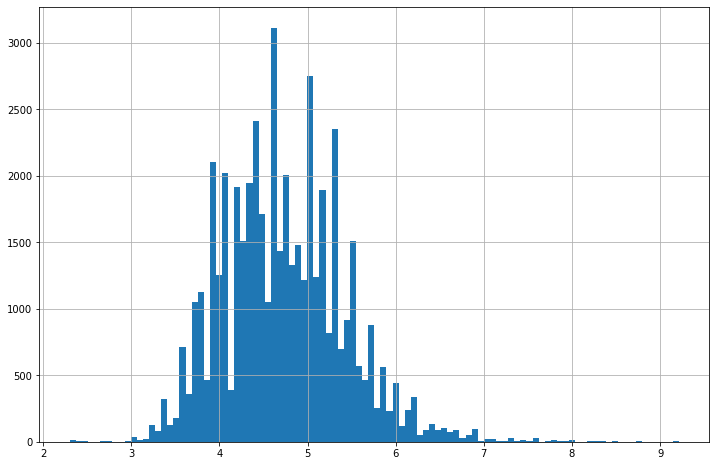

In [39]:
np.log(data['price']).hist(bins = 100)

уже похоже на нормальное распределение

In [40]:
data['log_price'] = np.log(data['price'])

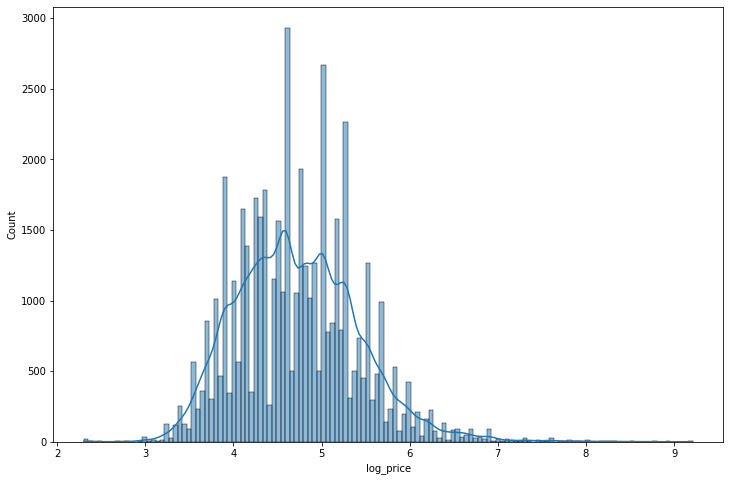

In [41]:
sns.histplot(data=data, x="log_price", kde=True)

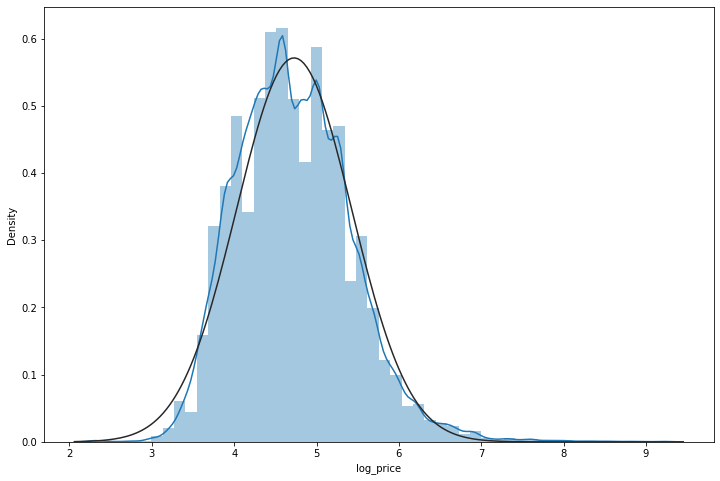

In [42]:
sns.distplot(data['log_price'], fit=norm)

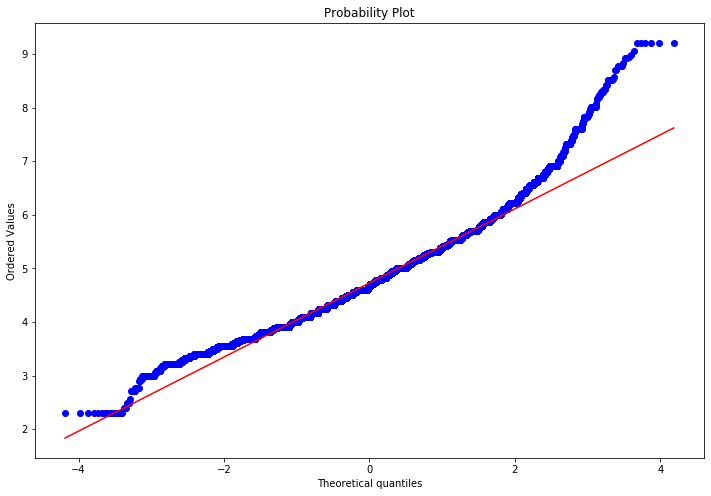

In [43]:
stats.probplot(data['log_price'], plot=plt)
plt.show()

видим, что целевая переменная после логарифмирования распределена нормалоьно

# Часть 3. Моделирование и улучшение качества модели с помощью future ingenering (baseline, доп фичи)

функция для записи метрик качества

In [44]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats

measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
RMSE
R2
MAPE


### baseline (предсказания =  median, mean)

In [45]:
data.columns.to_list()

['neighbourhood',
 'latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'neighbourhood_group_Brooklyn',
 'neighbourhood_group_Manhattan',
 'neighbourhood_group_Queens',
 'neighbourhood_group_Staten Island',
 'neighbourhood_freq',
 'room_type_Private room',
 'room_type_Shared room',
 'reviews_per_month_random',
 'reviews_per_month_mean',
 'reviews_per_month_zero',
 'log_price']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['price','log_price','neighbourhood','reviews_per_month','reviews_per_month_random','reviews_per_month_mean'], axis=1), 
    data['log_price'], 
    test_size=0.3
)

In [47]:
X_train.shape, X_test.shape

((34218, 14), (14666, 14))

In [48]:
median_train = y_train.median()
mean_train = y_train.mean()

In [49]:
y_test_baseline_median = np.array([median_train]*len(y_test))
y_test_baseline_mean = np.array([mean_train]*len(y_test))

In [50]:
measured_metrics["baseline_median"] = dataframe_metrics(y_test, y_test_baseline_median)
measured_metrics["baseline_mean"] = dataframe_metrics(y_test, y_test_baseline_mean)
measured_metrics

,error_type,baseline_median,baseline_mean
0,MAE,0.552621,0.553657
1,RMSE,0.701938,0.697842
2,R2,-0.011807,-0.000032
3,MAPE,11.739620,11.942985


### baseline log_reg, lassoCV, rigeCV, elasticnet_CV

In [51]:
continuous_vars = [
  'latitude', 
  'longitude',
  'minimum_nights',
 'number_of_reviews',
 'reviews_per_month_zero',
 'calculated_host_listings_count',
 'availability_365',
]

In [52]:
scaler = StandardScaler()

In [53]:
X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])
X_test[continuous_vars] = scaler.transform(X_test[continuous_vars])

In [54]:
X_train.head()

,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_freq,room_type_Private room,room_type_Shared room,reviews_per_month_zero
2610,-0.743979,1.651368,1.041079,1.518163,-0.094473,1.614303,1,0,0,0,0.002761,1,0,0.102589
24625,0.182619,-0.979271,-0.250245,0.016914,-0.186170,-0.702998,0,1,0,0,0.022763,0,0,0.033088
37480,1.704114,-0.037515,1.140412,-0.520847,-0.155604,1.036877,0,1,0,0,0.054361,1,0,-0.687192
16803,0.455341,0.439858,-0.200578,0.375421,-0.155604,1.918212,0,0,1,0,0.010983,0,0,0.228954
22886,-0.619431,0.267095,-0.250245,0.532268,-0.186170,-0.269929,1,0,0,0,0.075959,1,0,0.456411


In [55]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
measured_metrics["lin_reg"] = dataframe_metrics(y_test, lin_reg.predict(X_test))
measured_metrics

,error_type,baseline_median,baseline_mean,lin_reg
0,MAE,0.552621,0.553657,0.360964
1,RMSE,0.701938,0.697842,0.495772
2,R2,-0.011807,-0.000032,0.495265
3,MAPE,11.739620,11.942985,7.628493


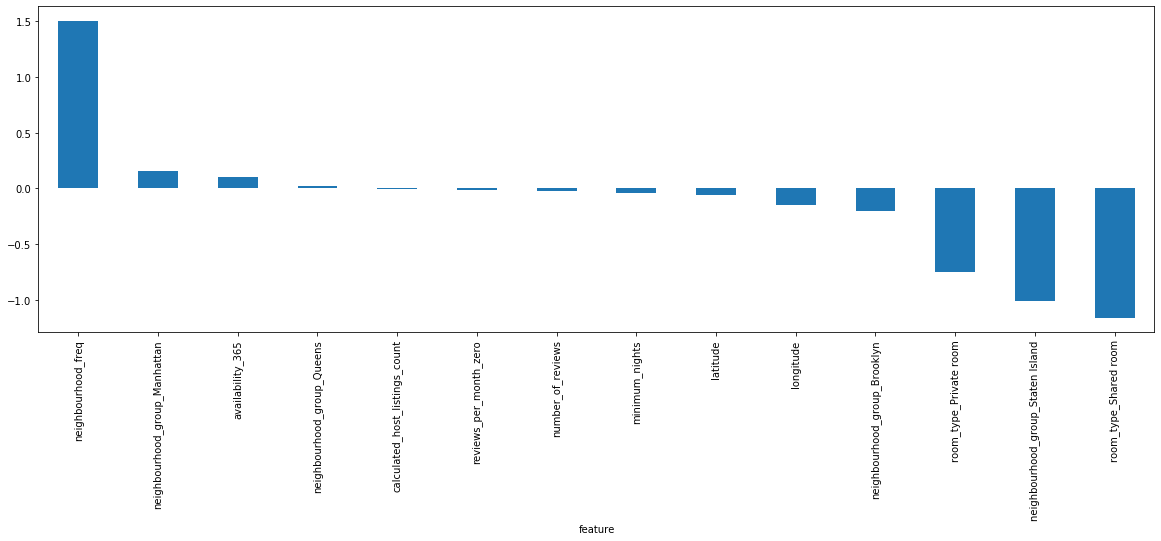

In [57]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": lin_reg.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind = 'bar', figsize=(20, 6));

### Ridge CV

In [58]:
ridge_cv = RidgeCV()
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

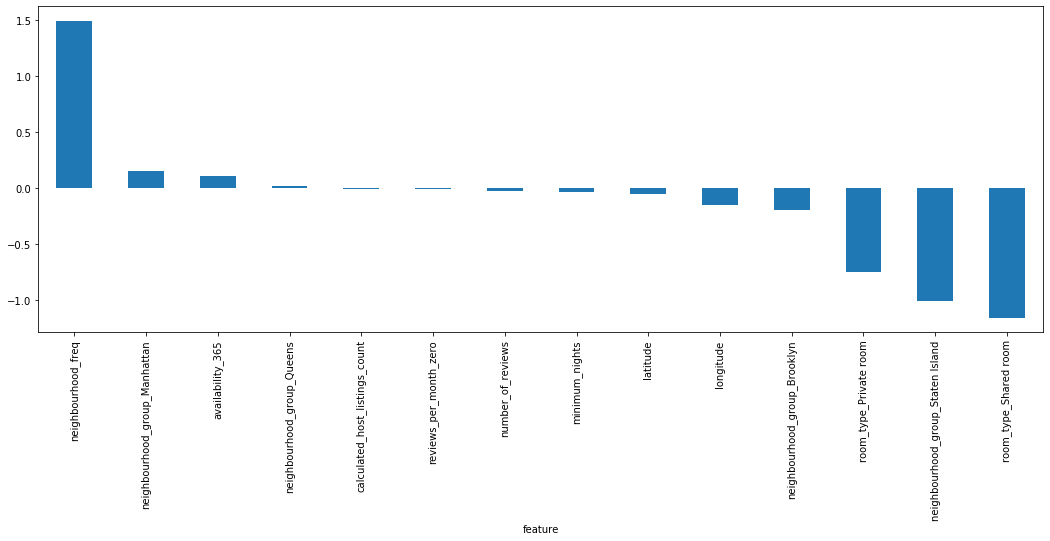

In [59]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": ridge_cv.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind = 'bar', figsize=(18, 6));

In [60]:
measured_metrics["ridge_cv"] = dataframe_metrics(y_test, ridge_cv.predict(X_test))
measured_metrics

,error_type,baseline_median,baseline_mean,lin_reg,ridge_cv
0,MAE,0.552621,0.553657,0.360964,0.360964
1,RMSE,0.701938,0.697842,0.495772,0.495773
2,R2,-0.011807,-0.000032,0.495265,0.495262
3,MAPE,11.739620,11.942985,7.628493,7.628503


### Lasso CV

In [61]:
lasso_cv = LassoCV()
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

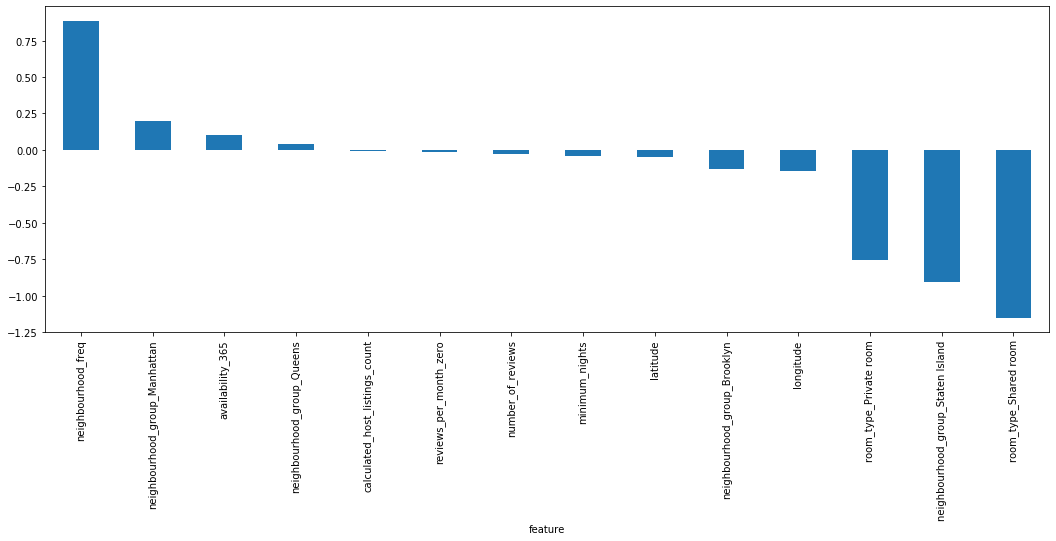

In [62]:
featureImportance = pd.DataFrame({"feature": X_train.columns[lasso_cv.coef_!=0], 
                                  "importance": lasso_cv.coef_[lasso_cv.coef_!=0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind = 'bar', figsize=(18, 6));

In [63]:
measured_metrics["lasso_cv"] = dataframe_metrics(y_test, lasso_cv.predict(X_test))
measured_metrics

,error_type,baseline_median,baseline_mean,lin_reg,ridge_cv,lasso_cv
0,MAE,0.552621,0.553657,0.360964,0.360964,0.361060
1,RMSE,0.701938,0.697842,0.495772,0.495773,0.495993
2,R2,-0.011807,-0.000032,0.495265,0.495262,0.494815
3,MAPE,11.739620,11.942985,7.628493,7.628503,7.631662


### ElasticNet CV

In [64]:
elastic_cv = ElasticNetCV()
elastic_cv.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

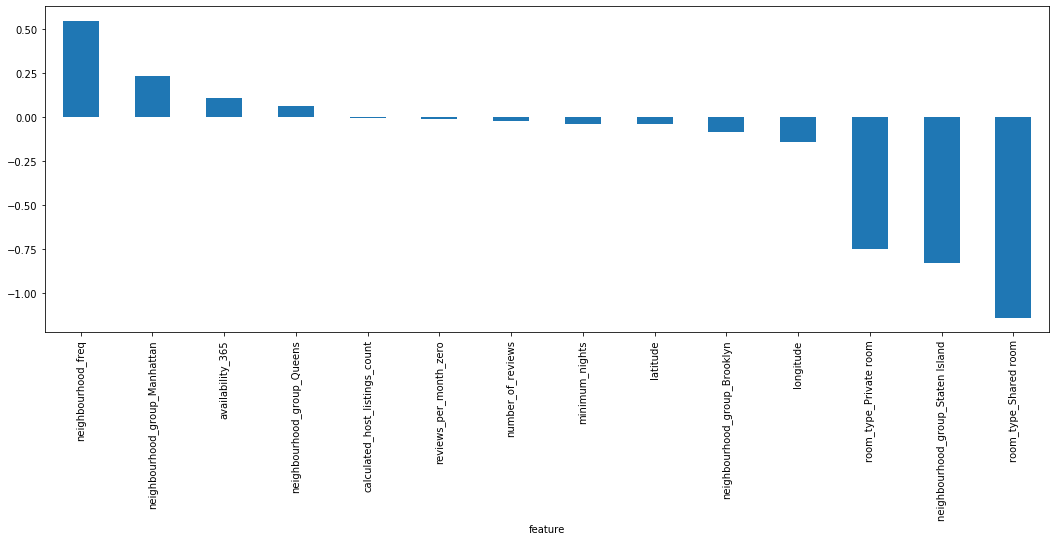

In [65]:
featureImportance = pd.DataFrame({"feature": X_train.columns[elastic_cv.coef_!=0], 
                                  "importance": elastic_cv.coef_[elastic_cv.coef_!=0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind = 'bar', figsize=(18, 6));

In [66]:
measured_metrics["elastic_cv"] = dataframe_metrics(y_test, elastic_cv.predict(X_test))
measured_metrics

,error_type,baseline_median,baseline_mean,lin_reg,ridge_cv,lasso_cv,elastic_cv
0,MAE,0.552621,0.553657,0.360964,0.360964,0.361060,0.361257
1,RMSE,0.701938,0.697842,0.495772,0.495773,0.495993,0.496253
2,R2,-0.011807,-0.000032,0.495265,0.495262,0.494815,0.494284
3,MAPE,11.739620,11.942985,7.628493,7.628503,7.631662,7.636934


### улучшение модели (обработка latitude, longitude)

возьмем за центh нью-йорка - центр Central Park (40.782748, -73.965743), создадим новую фичу - расстояние от недвижимости до центра Central Park

In [67]:
data['dist_manh'] = np.sqrt((data['latitude']  - 40.782748)**2 + (data['longitude']-(-73.965743))**2)

In [68]:
data.head()

,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,neighbourhood_freq,room_type_Private room,room_type_Shared room,reviews_per_month_random,reviews_per_month_mean,reviews_per_month_zero,log_price,dist_manh
0,Kensington,40.64749,-73.97237,149,1,9,0.21,6,365,1,0,0,0,0.003579,1,0,0.21,0.210000,0.21,5.003946,0.135420
1,Midtown,40.75362,-73.98377,225,1,45,0.38,2,355,0,1,0,0,0.031598,0,0,0.38,0.380000,0.38,5.416100,0.034255
2,Harlem,40.80902,-73.94190,150,3,0,NaN,1,365,0,1,0,0,0.054361,1,0,3.33,1.373221,0.00,5.010635,0.035478
3,Clinton Hill,40.68514,-73.95976,89,1,270,4.64,1,194,1,0,0,0,0.011699,0,0,4.64,4.640000,4.64,4.488636,0.097791
4,East Harlem,40.79851,-73.94399,80,10,9,0.10,1,0,0,1,0,0,0.022845,0,0,0.10,0.100000,0.10,4.382027,0.026863


In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['price','log_price','neighbourhood','latitude','longitude','reviews_per_month','reviews_per_month_random','reviews_per_month_mean'], axis=1), 
    data['log_price'], 
    test_size=0.3
)
continuous_vars = [
  'dist_manh', 
  'minimum_nights',
 'number_of_reviews',
 'reviews_per_month_zero',
 'calculated_host_listings_count',
 'availability_365',
]
scaler = StandardScaler()
X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])
X_test[continuous_vars] = scaler.transform(X_test[continuous_vars])
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
ridge_cv = RidgeCV()
ridge_cv.fit(X_train, y_train)
lasso_cv = LassoCV()
lasso_cv.fit(X_train, y_train)
elastic_cv = ElasticNetCV()
elastic_cv.fit(X_train, y_train)
measured_metrics["lin_reg_manh_dist"] = dataframe_metrics(y_test, lin_reg.predict(X_test))
measured_metrics["ridge_cv_manh_dist"] = dataframe_metrics(y_test, ridge_cv.predict(X_test))
measured_metrics["lasso_cv_manh_dist"] = dataframe_metrics(y_test, lasso_cv.predict(X_test))
measured_metrics

,error_type,baseline_median,baseline_mean,lin_reg,ridge_cv,lasso_cv,elastic_cv,lin_reg_manh_dist,ridge_cv_manh_dist,lasso_cv_manh_dist
0,MAE,0.552621,0.553657,0.360964,0.360964,0.361060,0.361257,0.368214,0.368216,0.368544
1,RMSE,0.701938,0.697842,0.495772,0.495773,0.495993,0.496253,0.506922,0.506924,0.507226
2,R2,-0.011807,-0.000032,0.495265,0.495262,0.494815,0.494284,0.474763,0.474758,0.474133
3,MAPE,11.739620,11.942985,7.628493,7.628503,7.631662,7.636934,7.768168,7.768215,7.775666


новая фича не улучшила модель

### улучшение модели (обработка min_max_scaller)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['price','log_price','neighbourhood','dist_manh','reviews_per_month','reviews_per_month_random','reviews_per_month_mean'], axis=1), 
    data['log_price'], 
    test_size=0.3
)
continuous_vars = [
  'latitude', 
  'longitude',
  'minimum_nights',
 'number_of_reviews',
 'reviews_per_month_zero',
 'calculated_host_listings_count',
 'availability_365',
]
scaler = MinMaxScaler()
X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])
X_test[continuous_vars] = scaler.transform(X_test[continuous_vars])
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
ridge_cv = RidgeCV()
ridge_cv.fit(X_train, y_train)
lasso_cv = LassoCV()
lasso_cv.fit(X_train, y_train)
elastic_cv = ElasticNetCV()
elastic_cv.fit(X_train, y_train)
measured_metrics["lin_reg_minmax"] = dataframe_metrics(y_test, lin_reg.predict(X_test))
measured_metrics["ridge_cv_minmax"] = dataframe_metrics(y_test, ridge_cv.predict(X_test))
measured_metrics["lasso_cv_minmax"] = dataframe_metrics(y_test, lasso_cv.predict(X_test))
measured_metrics

,error_type,baseline_median,baseline_mean,lin_reg,ridge_cv,lasso_cv,elastic_cv,lin_reg_manh_dist,ridge_cv_manh_dist,lasso_cv_manh_dist,lin_reg_minmax,ridge_cv_minmax,lasso_cv_minmax
0,MAE,0.552621,0.553657,0.360964,0.360964,0.361060,0.361257,0.368214,0.368216,0.368544,0.362733,0.362819,0.362994
1,RMSE,0.701938,0.697842,0.495772,0.495773,0.495993,0.496253,0.506922,0.506924,0.507226,0.499528,0.499534,0.499830
2,R2,-0.011807,-0.000032,0.495265,0.495262,0.494815,0.494284,0.474763,0.474758,0.474133,0.484593,0.484581,0.483971
3,MAPE,11.739620,11.942985,7.628493,7.628503,7.631662,7.636934,7.768168,7.768215,7.775666,7.669746,7.672141,7.677352


### улучшение модели robustscaller

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['price','log_price','neighbourhood','dist_manh','reviews_per_month','reviews_per_month_random','reviews_per_month_mean'], axis=1), 
    data['log_price'], 
    test_size=0.3
)
continuous_vars = [
  'latitude', 
  'longitude',
  'minimum_nights',
 'number_of_reviews',
 'reviews_per_month_zero',
 'calculated_host_listings_count',
 'availability_365',
]
scaler = RobustScaler()
X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])
X_test[continuous_vars] = scaler.transform(X_test[continuous_vars])
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
ridge_cv = RidgeCV()
ridge_cv.fit(X_train, y_train)
lasso_cv = LassoCV()
lasso_cv.fit(X_train, y_train)
elastic_cv = ElasticNetCV()
elastic_cv.fit(X_train, y_train)
measured_metrics["lin_reg_robust"] = dataframe_metrics(y_test, lin_reg.predict(X_test))
measured_metrics["ridge_cv_robust"] = dataframe_metrics(y_test, ridge_cv.predict(X_test))
measured_metrics["lasso_cv_robust"] = dataframe_metrics(y_test, lasso_cv.predict(X_test))
measured_metrics

,error_type,baseline_median,baseline_mean,lin_reg,ridge_cv,lasso_cv,elastic_cv,lin_reg_manh_dist,ridge_cv_manh_dist,lasso_cv_manh_dist,lin_reg_minmax,ridge_cv_minmax,lasso_cv_minmax,lin_reg_robust,ridge_cv_robust,lasso_cv_robust
0,MAE,0.552621,0.553657,0.360964,0.360964,0.361060,0.361257,0.368214,0.368216,0.368544,0.362733,0.362819,0.362994,0.360272,0.360274,0.363005
1,RMSE,0.701938,0.697842,0.495772,0.495773,0.495993,0.496253,0.506922,0.506924,0.507226,0.499528,0.499534,0.499830,0.495004,0.495002,0.498898
2,R2,-0.011807,-0.000032,0.495265,0.495262,0.494815,0.494284,0.474763,0.474758,0.474133,0.484593,0.484581,0.483971,0.495907,0.495912,0.487944
3,MAPE,11.739620,11.942985,7.628493,7.628503,7.631662,7.636934,7.768168,7.768215,7.775666,7.669746,7.672141,7.677352,7.594587,7.594647,7.667996


### улучшение модели (убираем фичу avaible_365)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['availability_365','price','log_price','neighbourhood','dist_manh','reviews_per_month','reviews_per_month_random','reviews_per_month_mean'], axis=1), 
    data['log_price'], 
    test_size=0.3
)
continuous_vars = [
  'latitude', 
  'longitude',
  'minimum_nights',
 'number_of_reviews',
 'reviews_per_month_zero',
 'calculated_host_listings_count',
]
scaler = RobustScaler()
X_train[continuous_vars] = scaler.fit_transform(X_train[continuous_vars])
X_test[continuous_vars] = scaler.transform(X_test[continuous_vars])
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
ridge_cv = RidgeCV()
ridge_cv.fit(X_train, y_train)
lasso_cv = LassoCV()
lasso_cv.fit(X_train, y_train)
elastic_cv = ElasticNetCV()
elastic_cv.fit(X_train, y_train)
measured_metrics["lin_reg_no_365"] = dataframe_metrics(y_test, lin_reg.predict(X_test))
measured_metrics["ridge_cv_no_365"] = dataframe_metrics(y_test, ridge_cv.predict(X_test))
measured_metrics["lasso_cv_no_365"] = dataframe_metrics(y_test, lasso_cv.predict(X_test))
measured_metrics

,error_type,baseline_median,baseline_mean,lin_reg,ridge_cv,lasso_cv,elastic_cv,lin_reg_manh_dist,ridge_cv_manh_dist,lasso_cv_manh_dist,lin_reg_minmax,ridge_cv_minmax,lasso_cv_minmax,lin_reg_robust,ridge_cv_robust,lasso_cv_robust,lin_reg_no_365,ridge_cv_no_365,lasso_cv_no_365
0,MAE,0.552621,0.553657,0.360964,0.360964,0.361060,0.361257,0.368214,0.368216,0.368544,0.362733,0.362819,0.362994,0.360272,0.360274,0.363005,0.368039,0.368037,0.369826
1,RMSE,0.701938,0.697842,0.495772,0.495773,0.495993,0.496253,0.506922,0.506924,0.507226,0.499528,0.499534,0.499830,0.495004,0.495002,0.498898,0.510643,0.510640,0.513685
2,R2,-0.011807,-0.000032,0.495265,0.495262,0.494815,0.494284,0.474763,0.474758,0.474133,0.484593,0.484581,0.483971,0.495907,0.495912,0.487944,0.472819,0.472826,0.466519
3,MAPE,11.739620,11.942985,7.628493,7.628503,7.631662,7.636934,7.768168,7.768215,7.775666,7.669746,7.672141,7.677352,7.594587,7.594647,7.667996,7.689093,7.689060,7.741672


### пробы random_forest

In [73]:
from sklearn.ensemble import RandomForestRegressor

In [74]:
rf_reg = RandomForestRegressor(n_jobs=-1)
rf_reg.fit(X_train, y_train)

measured_metrics["rf_reg"] = dataframe_metrics(y_test, rf_reg.predict(X_test))
measured_metrics

,error_type,baseline_median,baseline_mean,lin_reg,ridge_cv,lasso_cv,elastic_cv,lin_reg_manh_dist,ridge_cv_manh_dist,lasso_cv_manh_dist,lin_reg_minmax,ridge_cv_minmax,lasso_cv_minmax,lin_reg_robust,ridge_cv_robust,lasso_cv_robust,lin_reg_no_365,ridge_cv_no_365,lasso_cv_no_365,rf_reg
0,MAE,0.552621,0.553657,0.360964,0.360964,0.361060,0.361257,0.368214,0.368216,0.368544,0.362733,0.362819,0.362994,0.360272,0.360274,0.363005,0.368039,0.368037,0.369826,0.342984
1,RMSE,0.701938,0.697842,0.495772,0.495773,0.495993,0.496253,0.506922,0.506924,0.507226,0.499528,0.499534,0.499830,0.495004,0.495002,0.498898,0.510643,0.510640,0.513685,0.482658
2,R2,-0.011807,-0.000032,0.495265,0.495262,0.494815,0.494284,0.474763,0.474758,0.474133,0.484593,0.484581,0.483971,0.495907,0.495912,0.487944,0.472819,0.472826,0.466519,0.529018
3,MAPE,11.739620,11.942985,7.628493,7.628503,7.631662,7.636934,7.768168,7.768215,7.775666,7.669746,7.672141,7.677352,7.594587,7.594647,7.667996,7.689093,7.689060,7.741672,7.154648
